In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from keras. utils.vis_utils import plot_model
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv('TATAMOTORS.csv',usecols=['Date', 'Open', 'High', 'Low', 'Volume','VWAP','Prev Close'])
df.head()

,Date,Prev Close,Open,High,Low,VWAP,Volume
0,03-01-2000,201.60,207.4,217.25,207.4,214.28,676126
1,04-01-2000,216.75,217.0,219.00,206.0,209.50,679215
2,05-01-2000,208.20,194.0,217.80,194.0,210.33,1120951
3,06-01-2000,213.25,215.0,229.90,215.0,225.29,1968998
4,07-01-2000,222.10,224.0,239.90,223.1,236.32,2199431


In [3]:
#Print the shape of Dataframe  and Check for Null Values
print('Dataframe Shape: ', df. shape)
print('Null Value Present: ', df.isnull().values.any())

Dataframe Shape:  (5306, 7)
Null Value Present:  False


<Axes: >

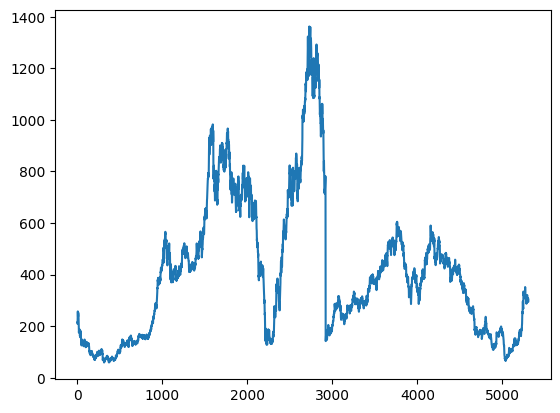

In [4]:
#Plot the True Adj Close Value
df['VWAP'].plot()

In [5]:
#Set Target Variable
output_var = pd.DataFrame(df['VWAP'])
#Selecting the Feature
features = ['Open', 'Low', 'High', 'Prev Close','Volume']

In [6]:
from sklearn.preprocessing import MinMaxScaler

#Scaling
scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(df[features])
feature_transform= pd.DataFrame(columns=features, data=feature_transform, index=df.index)
feature_transform.head()

,Open,Low,High,Prev Close,Volume
0,0.114658,0.116212,0.118482,0.109312,0.001700
1,0.122026,0.115127,0.119806,0.120909,0.001707
2,0.104375,0.105820,0.118898,0.114364,0.002838
3,0.120491,0.122106,0.128056,0.118230,0.005010
4,0.127398,0.128388,0.135624,0.125005,0.005600


In [7]:
from sklearn.model_selection import TimeSeriesSplit

#Splitting to Training set and Test set
timesplit=TimeSeriesSplit(n_splits=20)
for train_index, test_index in timesplit.split(feature_transform):
        X_train, X_test = feature_transform[:len(train_index)], feature_transform[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = output_var[:len(train_index)].values.ravel(), output_var[len(train_index): (len(train_index)+len(test_index))].values.ravel()

In [8]:
#Process the data for LSTM
trainX =np.array(X_train)
testX =np.array(X_test)
X_train = trainX.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])

In [9]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

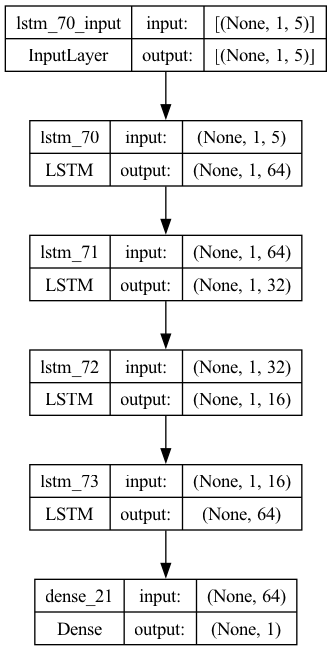

In [83]:
#Building the LSTM Model
lstm = Sequential()
lstm.add(LSTM(64, input_shape=(1, trainX.shape[1]), activation='tanh', return_sequences=True))
lstm.add(LSTM(32, activation='tanh', return_sequences=True))
lstm.add(LSTM(16, activation='tanh', return_sequences=True))
lstm.add(LSTM(64, activation='tanh', return_sequences=False))

lstm.add(Dense(1))

lstm.compile(loss='mean_squared_error', 
             optimizer='adam',
             #learning_rate=0.01
             )

plot_model(lstm, show_shapes=True, show_layer_names=True)


In [84]:
print("Is GPU available:", tf.config.list_physical_devices('GPU'))
# print("Using CUDA:", tf.test.is_built_with_cuda())


Is GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [85]:
from keras.callbacks import EarlyStopping,ModelCheckpoint

Model_checkpoint_path = "TataMotors_Stock_Price_Prediction.hdf5"

callback = [EarlyStopping(monitor='loss', patience = 10, verbose=1),
            ModelCheckpoint(Model_checkpoint_path, monitor='loss', verbose=1, save_best_only=True, mode='auto')]

In [86]:
with tf.device('GPU'):
    history=lstm.fit(X_train, 
                     y_train, 
                     epochs=500, 
                     batch_size=32,
                     verbose=1, 
                     shuffle=False, 
                     callbacks=callback)

Epoch 1/500
158/158 [==============================] - ETA: 0s - loss: 247534.2656
Epoch 1: loss improved from inf to 247534.26562, saving model to TataMotors_Stock_Price_Prediction.hdf5
158/158 [==============================] - 5s 14ms/step - loss: 247534.2656
Epoch 2/500
157/158 [============================>.] - ETA: 0s - loss: 236632.3281
Epoch 2: loss improved from 247534.26562 to 235242.09375, saving model to TataMotors_Stock_Price_Prediction.hdf5
158/158 [==============================] - 2s 13ms/step - loss: 235242.0938
Epoch 3/500
157/158 [============================>.] - ETA: 0s - loss: 229462.0938
Epoch 3: loss improved from 235242.09375 to 228110.07812, saving model to TataMotors_Stock_Price_Prediction.hdf5
158/158 [==============================] - 2s 13ms/step - loss: 228110.0781
Epoch 4/500
155/158 [============================>.] - ETA: 0s - loss: 226204.7031
Epoch 4: loss improved from 228110.07812 to 222223.62500, saving model to TataMotors_Stock_Price_Prediction.hd

In [28]:
#LSTM Prediction
y_pred= lstm.predict(X_test)

8/8 [==============================] - 1s 8ms/step


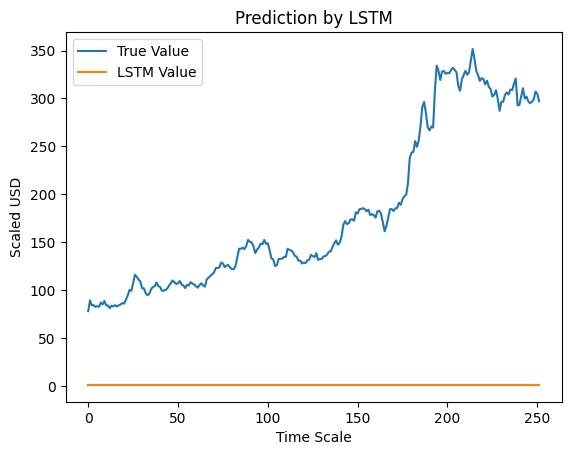

In [29]:
from matplotlib import pyplot as plt

#Predicted vs True Adj Close Value – LSTM

plt.plot(y_test, label='True Value')
plt.plot(y_pred, label='LSTM Value')
plt.title('Prediction by LSTM')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.show()

In [21]:
X_test[0]

array([[0.01492709, 0.01407705, 0.01473496, 0.10439395]])

In [1]:
lstm.predict(X_test[0].reshape(1,1,4))

NameError: name 'lstm' is not defined

In [26]:
lstm.get_build_config()

{'input_shape': (None, 1, 4)}

In [31]:
lstm.save('TataMotors_Stock_Price_Prediction.h5')

In [39]:
features = ['Open', 'High', 'Low', 'Volume']

open_price = float(input("Enter Open Price: "))

high_price = float(input("Enter High Price: "))

low_price = float(input("Enter Low Price: "))

volume = float(input("Enter Volume: "))

user_input = [[open_price, high_price, low_price, volume]]

user_input = scaler.transform(user_input)

user_input = np.array(user_input)

user_input = user_input.reshape(1, 1, 4)

lstm.predict(user_input)

In [ ]:
from tensorflow.keras.models import load_model
import numpy as np

# Load the model
model = load_model('TataMotors_Stock_Price_Prediction.h5')

# Example input data (you should replace these with your actual input features)
open_price = 1072.0
high_price = 310.0
low_price = 295.0
volume = 100000

# Prepare the input data
input_data = np.array([[open_price, high_price, low_price, volume]])
input_data = np.reshape(input_data, (input_data.shape[0], input_data.shape[1], 1))  # Adjust shape as necessary

# Predict the stock price
prediction = model.predict(input_data)

# Print the predicted stock price
print("Predicted Stock Price:", prediction[0][0])
